## **Notes For Markers**
**Timing disclaimer:** Absolute times and exact ratios vary across machines (CPU, RAM, Python build). We therefore focus on trends and relative behavior (shape of curves, rank ordering, and presence/absence of crossover), not specific numeric values. 

**Runtime disclaimer:** This notebook takes a significant amount of time to run, particularly for slower laptops. Do not be alarmed if it takes up to minutes to run

**AI Disclaimer:** AI (ChatGPT) was used for the following purposes (in varying degrees) in our assignment,
1) Idea Generation
3) Code Generation
3) Debugging

## **Executive Summary**
This project investigates the real-world performance of HashSet and Trie data structures in Python by comparing their lookup behaviors under different workloads and structural variations.

While both structures have clear theoretical time complexities, O(1) for HashSet and O(m) for Trie, our experiments reveal how implementation details, workload characteristics, and hardware behavior shape actual runtime performance far beyond what asymptotic analysis predicts.

**Experiment 1 — Lookup Runtime vs Number of Reviews (N)**
- We first compared baseline lookup performance using identical workloads.
- While theory predicts a large gap (O(1) vs O(m)), practical testing showed that both structures perform almost the same per word, since English words are short (5–8 characters) and m behaves like a constant.
- Both end up “touching” each character once, HashSet through hash computation, and Trie through pointer traversal, so total runtime scales linearly with the dataset size (O(N)).
- The Trie was about 2.2× slower because of constant-factor costs such as Python object overhead and poorer cache locality.

**Key lesson:** **Big-O describes growth, not real speed. Constant factors, data shape, and environment determine actual performance.**

---

**Experiment 2 — Lookup Runtime vs Prefix Overlap**
- Next, we attempted to create conditions favoring the Trie by increasing prefix overlap and varying average word length (m).
- Lexicon subsets were grouped by their first few characters (L = 3–5) to encourage shared branches, and coverage levels were varied (10 %, 30 %, 60 %).
- Despite these adjustments, the Trie remained 2.7–3.0× slower. Its theoretical advantages (prefix reuse and early termination) were overwhelmed by Python interpreter overhead and per-lookup dictionary costs.

**Key lesson:** **Implementation and runtime language can outweigh theoretical efficiency**. **Even if we optimize m or structural overlap, the Trie cannot overcome the high constant factors inherent to interpreted programming environments like Python, where each lookup incurs additional object and memory-management overhead.**

---

**Experiment 3 — Lookup Runtime vs Workload Characteristics (Hit/Miss Ratio & Access Order)**
- Finally, we examined how workload characteristics affect runtime.
- By varying hit/miss ratios and access order (random vs prefix-clustered), we found that Trie performance is far more sensitive to workload patterns than HashSet.
- When tokens were clustered by their first 4 characters, both structures improved, but for different reasons:
  
  (1) Trie gained from genuine cache reuse along shared prefix paths
  
  (2) HashSet benefited from Python string interning and hash caching.
  
- These findings reveal that memory locality and data ordering can unlock real speedups even when asymptotic complexity remains unchanged.

**key lesson:** **Real-world performance depends not only on algorithmic complexity**, **but also on how data is accessed and how it interacts with the system’s memory and runtime environment**. **Workload design and memory locality can significantly influence runtime even when theoretical complexities remain unchanged**

---

**Cross-Experiment Insights**
Across all experiments, **one theme persisted**:
- Theoretical complexity does not guarantee real-world performance. Actual efficiency depends on how a data structure interacts with its language runtime, memory layout, and workload.

In practice:
- **Big-O Complexity Isn’t the Whole Story** - it predicts scaling, not real runtime.

- **Constant Factors and Implementation Matter** - The same logic implemented in C versus Python can differ by several multiples.

- **Workload Sensitivity Drives Performance** - Access order, cache behavior, and hit/miss patterns can influence runtime more than algorithm choice.

- **No Universal “Best” Structure** - The optimal choice depends on the problem context, data characteristics, and environment.

## **Libraries**

In [2]:
### Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
import re
import math
import csv
import pickle
import random
import platform
import statistics as stats
from time import perf_counter
import sys

# Add project root to path to allow importing 'src' module
if '..' not in sys.path:
    sys.path.insert(0, '..')

### Our Modules
from src.sentiment_scorer import HashSetSentimentScorer, TrieSentimentScorer, tokenize
from src.utils import measure_time, measure_memory

print("Imports successful")

Imports successful


In [5]:
def show_environment_info():
    print("=== Environment Information ===")
    print(f"Python version   : {sys.version.split()[0]}")
    print(f"Platform          : {platform.system()} {platform.release()} ({platform.version()})")
    print(f"Processor         : {platform.processor() or 'N/A'}")
    print(f"Machine           : {platform.machine()}")
    print(f"Architecture      : {platform.architecture()[0]}")
    print()
    print("=== Library Versions ===")
    print(f"pandas            : {pd.__version__}")
    print(f"numpy             : {np.__version__}")
    print(f"matplotlib.pyplot : {plt.__version__}")
    print(f"os, re, math, csv, pickle, random, platform, statistics, time, sys : built-in")
    print()
    print("=== Path Info ===")
    print(f"Working Directory : {os.getcwd()}")
    print(f"Project Root      : {Path('..').resolve()}")
    print(f"Python Path[0]    : {sys.path[0]}")
    print("===============================")

show_environment_info()

=== Environment Information ===
Python version   : 3.12.7
Platform          : Windows 11 (10.0.22631)
Processor         : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
Machine           : AMD64
Architecture      : 64bit

=== Library Versions ===
pandas            : 2.2.2
numpy             : 1.26.4


AttributeError: module 'matplotlib.pyplot' has no attribute '__version__'

## **Importing Kaggle Dataset**

In [3]:
## Load Dataset
print("Current working dir:", os.getcwd())
DATASET_PATH = Path("data/airline.csv")

if not DATASET_PATH.exists():
    raise FileNotFoundError(f"Dataset not found at {DATASET_PATH}")

print("Dataset located at:", DATASET_PATH)

Current working dir: C:\Users\marcl\DSA Assignment - Sentiment Analysis
Dataset located at: data\airline.csv


In [4]:
## Initialize Dataset as pandas dataframe
df = pd.read_csv(DATASET_PATH)

print("Rows:", len(df))
print("Columns:", list(df.columns))
df.head(3)

Rows: 41396
Columns: ['airline_name', 'link', 'title', 'author', 'author_country', 'date', 'content', 'aircraft', 'type_traveller', 'cabin_flown', 'route', 'overall_rating', 'seat_comfort_rating', 'cabin_staff_rating', 'food_beverages_rating', 'inflight_entertainment_rating', 'ground_service_rating', 'wifi_connectivity_rating', 'value_money_rating', 'recommended']


,airline_name,link,title,author,author_country,date,content,aircraft,type_traveller,cabin_flown,route,overall_rating,seat_comfort_rating,cabin_staff_rating,food_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_connectivity_rating,value_money_rating,recommended
0,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,D Ito,Germany,2015-04-10,Outbound flight FRA/PRN A319. 2 hours 10 min f...,NaN,NaN,Economy,NaN,7.0,4.0,4.0,4.0,0.0,NaN,NaN,4.0,1
1,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,Ron Kuhlmann,United States,2015-01-05,Two short hops ZRH-LJU and LJU-VIE. Very fast ...,NaN,NaN,Business Class,NaN,10.0,4.0,5.0,4.0,1.0,NaN,NaN,5.0,1
2,adria-airways,/airline-reviews/adria-airways,Adria Airways customer review,E Albin,Switzerland,2014-09-14,Flew Zurich-Ljubljana on JP365 newish CRJ900. ...,NaN,NaN,Economy,NaN,9.0,5.0,5.0,4.0,0.0,NaN,NaN,5.0,1


In [5]:
reviews = df.iloc[:, 6].fillna("").astype(str).tolist()
print(f"Loaded {len(reviews):,} reviews from column '{df.columns[6]}'")
print()
print("Example review:\n", reviews[0][:300])

Loaded 41,396 reviews from column 'content'

Example review:
 Outbound flight FRA/PRN A319. 2 hours 10 min flight. I thought drinks/snacks for sale but sandwich soft drinks were served complimentary. Inbound flights SKP/LJU/FRA CRJ900. each 1 hour 30 min flight. Skyshop menu was in a seat pocket and drinks/snacks were for sale. All flight crews were friendly. 


##  **Importing Lexicon Dataset**

In [6]:
POS_PATH = Path("data/positive-words.txt")
NEG_PATH = Path("data/negative-words.txt")

LEX_TOKEN = re.compile(r"[a-z][a-z'\-\+]*$")

def load_lexicon(path: Path):
    words = []
    for line in path.read_text(encoding="latin-1").splitlines():
        s = line.strip().lower()
        if not s or s.startswith(";"):
            continue
        if LEX_TOKEN.fullmatch(s):
            words.append(s)
    return sorted(set(words))
    
pos_words = load_lexicon(POS_PATH)
neg_words = load_lexicon(NEG_PATH)

print(f"Loaded {len(pos_words):,} positive and {len(neg_words):,} negative words")
print("Examples (pos):", pos_words[:10])
print("Examples (neg):", neg_words[:10])

Loaded 2,006 positive and 4,776 negative words
Examples (pos): ['a+', 'abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation']
Examples (neg): ['abnormal', 'abolish', 'abominable', 'abominably', 'abominate', 'abomination', 'abort', 'aborted', 'aborts', 'abrade']


## **Sanity/Proof-of-Concept: Review Scoring**

In [7]:
# --- Step 1: Score all reviews using both data structures ---
hs = HashSetSentimentScorer(pos_words, neg_words)
tr = TrieSentimentScorer(pos_words, neg_words)

hs_scores = [hs.score_review(r) for r in reviews]
tr_scores = [tr.score_review(r) for r in reviews]

# --- Step 2: Compute summary statistics ---
total = len(reviews)
agree = np.sum(np.array(hs_scores) == np.array(tr_scores))
mismatch = total - agree

print("Scoring completed successfully.")
print(f"Total reviews scored: {total:,}")
print(f"Matching scores (HashSet vs Trie): {agree:,}")
print(f"Mismatches: {mismatch:,}")

# sentiment distribution
pos_count = np.sum(np.array(hs_scores) > 0)
neu_count = np.sum(np.array(hs_scores) == 0)
neg_count = np.sum(np.array(hs_scores) < 0)

print("\nHashSet Sentiment Distribution:")
print(f"  Positive: {pos_count:,} ({pos_count/total*100:.2f}%)")
print(f"  Neutral:  {neu_count:,} ({neu_count/total*100:.2f}%)")
print(f"  Negative: {neg_count:,} ({neg_count/total*100:.2f}%)")



Scoring completed successfully.
Total reviews scored: 41,396
Matching scores (HashSet vs Trie): 41,396
Mismatches: 0

HashSet Sentiment Distribution:
  Positive: 24,646 (59.54%)
  Neutral:  3,534 (8.54%)
  Negative: 13,216 (31.93%)


In [8]:
# --- Step 1: Randomly sample a few full reviews ---
random.seed(201)
sample_size = 10
idxs = random.sample(range(len(reviews)), sample_size)

# --- Step 2: Prepare comparison table with full review text ---
rows = []
for i in idxs:
    r = str(reviews[i]).replace("\n", " ").strip()
    hs_score = hs_scores[i]
    tr_score = tr_scores[i]
    rows.append({
        "Row #": i,
        "Full Review Text": r,
        "HashSet Score": hs_score,
        "Trie Score": tr_score,
        "Match": "Match" if hs_score == tr_score else "Mismatch"
    })

demo = pd.DataFrame(rows, columns=["Row #", "Full Review Text", "HashSet Score", "Trie Score", "Match"])

# --- Step 3: Highlight mismatches for visibility ---
def highlight_mismatch(row):
    color = "background-color: #ffeaea" if row["Match"] == "Mismatch" else ""
    return [color] * len(row)

demo.style.apply(highlight_mismatch, axis=1).format({
    "HashSet Score": "{:+d}",
    "Trie Score": "{:+d}"
})


,Row #,Full Review Text,HashSet Score,Trie Score,Match
0,4397,VIE to KIV. The experience was quite odd like going back into the Soviet days as they were using a Yak-40 on the flight. Staff friendly and relatively professional although it felt almost like a charter flight. The meal was quite good and flight was on time. The cabin layout was really bizarre with something looking like a couch near the front of the plane and little leg room in my seat. The fact that they didn't de-ice the plane (it was snowing hard at takeoff) freaked me out a bit too. Not sure if they're still using the Yak-40 but if you happen to get on this one it's certainly a unique experience if you're up for it.,+2,+2,Match
1,21338,"I've been flying back and forth with JetBlue for the past 6 years. I fly once every other month. At first I was so satisfied with the service that I have never flown with any other airline. But lately the past year especially the service has gone downhill. The staff used to be so friendly and always smiling. My last Flight was in December my TV was not working when I informed the flight attendant I got nothing but attitude and her answer was ""I don't know what to tell you."" After six years of using them that was my last and final time.",+2,+2,Match
2,27547,"BNE to Singapore. Checking in using machines just about everyone needed assistance. The seat allocation for my husband and I were many rows apart. Everyone ended up at the bag drop where this problem was sorted. A330 Airbus was cramped tired ditto the crew. Food less than ordinary no tray but just main meal container (one was cracked) plus roll and envelope with cutlery etc. Overheard passenger asking cabin crew member to recommend which of the meal choices - the reply was ""Madam I would recommend eating before you board the plane""! The pre- landing snack was a sort of pizza contained in a thick cardboard box - made in England. Entertainment programme was minimal. Return flight fortunately on a rather more modern plane better range of entertainment but the crew were brusque uncaring and disorganised - would not feel confident about them in a crisis. Never again on Qantas.",-1,-1,Match
3,240,Flew LHR to SVO 27/3/15 returned 4/4/15. Outbound A321 return A330-300. Both trips were comfortable with cabin crew all very helpful and pleasant to a non Russian Speaker. We were in economy both ways. The plane was clean the toilets were fine and the food and drinks provided were good for airline food in our family experience. Overall a very pleasant experience No IFE on way out as small plane but lots on way back choice was good.,+8,+8,Match
4,18533,CGK to PLY pleased with the service. Without delays and had good take-offs and landing. Inflight entertainment was good but could be better. Comfortable seat if compared to other airlines economy class. Price could be cheaper but not too expensive for service like that. The food was delicious for plane food.,+6,+6,Match
5,21376,Heathrow to Delhi. Very easy check-in at Heathrow using terminal 4 is great because it's a small terminal so queues are far shorter for check-in and security than in other terminals. My flight was delayed an hour. Had good inflight service and the food and entertainment was adequate. My main problem with this airline compared to using other airlines is the fellow passengers. Be prepared to put up with people pushing their way forward at the boarding gate and for a relatively noisy flight. So although the airline is fine if you can get an equivalent flight on this route I'd take it.,+2,+2,Match
6,30793,KCH-SIN A short and pleasant flight. Despite the crowded plane the cabin crew is still warm and friendly. SilkAir has finally launched new menus which makes frequent traveler more appertising. The ground staff is friendly and extends warm welcome to everyone. Also SilkAir has also introduced the new autumn theme seating. Simple soothing yet truly makes passengers feel exclusive. SilkAir also departs and arrives on tim

##  **Experiment 1 - Lookup Runtime vs Number of Reviews (N)**

**Objective**
- This experiment compares the runtime performance of HashSet and Trie when used to check if words in a review appear in a sentiment lexicon (positive or negative word list).
- We want to see how their theoretical time complexities play out when processing thousands of reviews.


**Algorithmic/Theory Context**
1. HashSet: Hash-Table-Based Constant-Time Lookup
    - A HashSet stores elements in an underlying hash table
    - Each word is passed through a hash function, which converts a string into an integer hash value.
    - This hash is then modded by the table size to compute an index, effectively pointing to a “bucket” in memory.
    - Because this process avoids traversing structures element-by-element, the expected lookup cost is constant time O(1), assuming a good hash function and even distribution of entries

2. Trie: Tree-Based Prefix Search Structure
    - A Trie (prefix tree) organizes words as paths of characters
    - Each node represents a single character, and edges represent transitions between successive letters. For instance, inserting “good” creates a path: root → g → o → o → d.
    - This traversal requires visiting m nodes (where m = length of the word), giving a lookup complexity of O(m).
    - Unlike a hash table, a Trie’s structure depends on the characters of the word rather than its hash value.

**Hypothesis**
With this theory in mind, it seems clear that Trie should be slower than HashSet by an extreme margin because O(m) is theoretically much worse than O(1)

**Experiment 1 Design**
- To test this hypothesis, we will measure how long both data structures (HashSet and Trie) take to process different amounts of reviews
- Each review is made up of many words, and for every word, the program checks whether it exists in the positive or negative lexicon
- Then it will make a judgement (positive or negative) on the review based on counts of positive or negative words

**Independent Variable:** The number of reviews (N) processed

**Controlled Variables:**
1. Same positive and negative word lists (lexicons)
2. Same review dataset, in the same order
3. Same scoring logic (each word checked once per review)
4. Fixed random seed (201, the course code) to make sampling consistent

**Measured Metrics:**
1. Total Runtime (s) – total time taken for each data structure to process all reviews
2. Average Time per Review (ms) – how much time each review takes on average
3. Relative Runtime (Trie ÷ HashSet) – to see how many times slower the Trie is compared to the HashSet

### **1.1 Testing Metrics Results**

In [9]:
def time_scorer(scorer, texts):
    """Return how many seconds it takes for scorer to process all given reviews."""
    start_time = perf_counter()
    for review in texts:
        scorer.score_review(review)   # run the scoring
    end_time = perf_counter()
    elapsed = end_time - start_time
    return elapsed

different_Ns   = [500, 1000, 2000, 5000, 10000, 20000, 30000, 40000]
repetitions = 3 # multiple runs for a stable/average median

results = []
prev_N = None
prev_hs_time = None
prev_tr_time = None

for N in different_Ns:
    subset = reviews[:N]
    hs = HashSetSentimentScorer(pos_words, neg_words)
    tr = TrieSentimentScorer(pos_words, neg_words)

    hs_times = [time_scorer(hs, subset) for i in range(repetitions)]
    tr_times = [time_scorer(tr, subset) for i in range(repetitions)]

    hs_med = stats.median(hs_times)
    tr_med = stats.median(tr_times)

    if prev_N is None:
        n_growth = None
        hs_growth = None
        tr_growth = None
    else:
        n_growth = N / prev_N
        hs_growth = hs_med / prev_hs_time
        tr_growth = tr_med / prev_tr_time

    results.append({
        "Reviews Processed": N,
        "HashSet Runtime (s)": hs_med,
        "Trie Runtime (s)": tr_med,
        "Relative Runtime (Trie ÷ HashSet)": tr_med / hs_med,
        "Avg Time/Review – HashSet (ms)": (hs_med / N) * 1000,
        "Avg Time/Review – Trie (ms)": (tr_med / N) * 1000,
        "N Growth (×)": n_growth,
        "Runtime Growth (×) — HashSet": hs_growth,
        "Runtime Growth (×) — Trie": tr_growth,
    })

    # update previous
    prev_N = N
    prev_hs_time = hs_med
    prev_tr_time = tr_med


### **1.1.1 Experiment 1 Results (Table)**

In [10]:
dfN = pd.DataFrame(results)

dfN_style = dfN.style.format({
    "HashSet Runtime (s)": "{:.4f}",
    "Trie Runtime (s)": "{:.4f}",
    "Relative Runtime (Trie ÷ HashSet)": "{:.2f}×",
    "N Growth (×)": lambda v: "" if pd.isna(v) else f"{v:.2f}",
    "Runtime Growth (×) — HashSet": lambda v: "" if pd.isna(v) else f"{v:.2f}",
    "Runtime Growth (×) — Trie": lambda v: "" if pd.isna(v) else f"{v:.2f}",
})
dfN_style


,Reviews Processed,HashSet Runtime (s),Trie Runtime (s),Relative Runtime (Trie ÷ HashSet),Avg Time/Review – HashSet (ms),Avg Time/Review – Trie (ms),N Growth (×),Runtime Growth (×) — HashSet,Runtime Growth (×) — Trie
0,500,0.0200,0.0427,2.13×,0.040064,0.085397,,,
1,1000,0.0376,0.0849,2.26×,0.037599,0.084876,2.00,1.88,1.99
2,2000,0.0765,0.1721,2.25×,0.038274,0.086065,2.00,2.04,2.03
3,5000,0.2086,0.4876,2.34×,0.041712,0.097529,2.50,2.72,2.83
4,10000,0.4384,0.9310,2.12×,0.043840,0.093104,2.00,2.10,1.91
5,20000,0.8414,1.8642,2.22×,0.042068,0.093208,2.00,1.92,2.00
6,30000,1.2227,2.8072,2.30×,0.040757,0.093575,1.50,1.45,1.51
7,40000,1.6597,3.6910,2.22×,0.041492,0.092275,1.33,1.36,1.31


#### **Conclusion**
- The table shows that **runtime** for both **HashSet** and **Trie imeplementations increases** roughly proportionally with number of reviews (N), this confirms **O(N) time complexity** for both data structures

- **"Avg Time per Review" remains nearly constant across all dataset sizes**, this means that each **additional review adds a fixed processing cost** (≈ 0.04 ms for HashSet, ≈ 0.09 ms for Trie)

- The **“Runtime Growth (×)” columns indicate near-linear growth (≈ 2× when N doubles)**, which is also reflected visually in Graph 1 (Total Runtime Scaling with Dataset Size) and Graph 4 (Runtime Growth Factor vs Dataset Growth Factor).

- The **Relative Runtime (Trie ÷ HashSet) ratio stabilizes around 2.2×**, indicating a **consistent constant-factor slowdown**

- These **quantitative results** are visually corroborated by **Graph 1 (Log–Log and Linear-Scale Plot)**, **Graph 2 (Average Processing Time per Review)**, and **Graph 3 (Relative Slowdown of Trie vs HashSet)**.

### **1.1.2 Experiment 1 Results (Graphs)**

#### **Graph 1 - Total Runtime Scaling with Dataset Size (Log–Log and Linear-Scale Plot)**

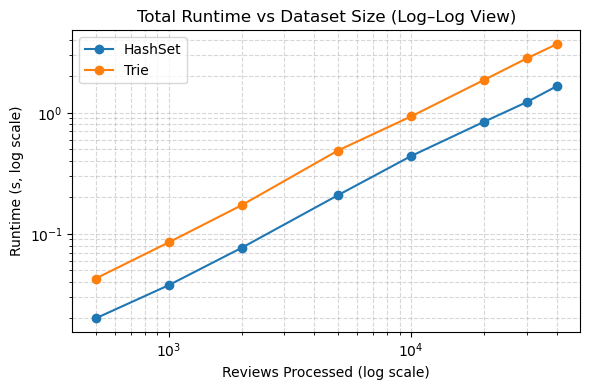

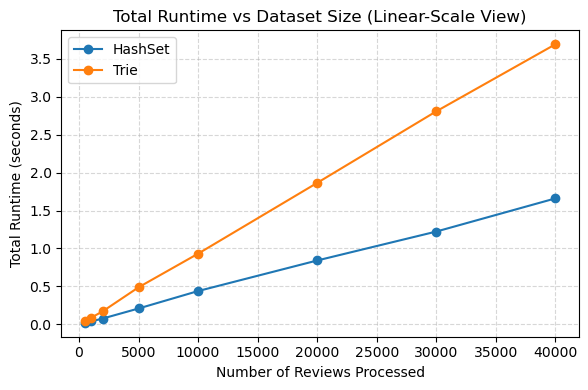

In [11]:
# Log-log plot for theory 
plt.figure(figsize=(6,4))
plt.loglog(dfN["Reviews Processed"], dfN["HashSet Runtime (s)"], marker="o", label="HashSet")
plt.loglog(dfN["Reviews Processed"], dfN["Trie Runtime (s)"], marker="o", label="Trie")
plt.xlabel("Reviews Processed (log scale)")
plt.ylabel("Runtime (s, log scale)")
plt.title("Total Runtime vs Dataset Size (Log–Log View)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Linear-scale plot for intuition and markers
plt.figure(figsize=(6,4))
plt.plot(dfN["Reviews Processed"], dfN["HashSet Runtime (s)"], marker="o", label="HashSet")
plt.plot(dfN["Reviews Processed"], dfN["Trie Runtime (s)"], marker="o", label="Trie")
plt.xlabel("Number of Reviews Processed")
plt.ylabel("Total Runtime (seconds)")
plt.title("Total Runtime vs Dataset Size (Linear-Scale View)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

#### **Findings/Conclusions**
- The log–log plot (above) highlights theoretical scaling: **both lines are straight and parallel**, **confirming linear O(N) time complexity** for both data structures.

- The linear-scale plot (below) presents the same data in real-world units, making absolute timing differences more intuitive. We found the log-log plot difficult to grasp intuitively

- Across all dataset sizes, **HashSet remains faster by roughly a constant factor** (~2× on this hardware)

- This shows that **while both data structures grow linearly** with input size, the **HashSet's lower constant factor** makes it **perform better for large datasets**

#### **Graph 2 - Average Processing Time per Review**

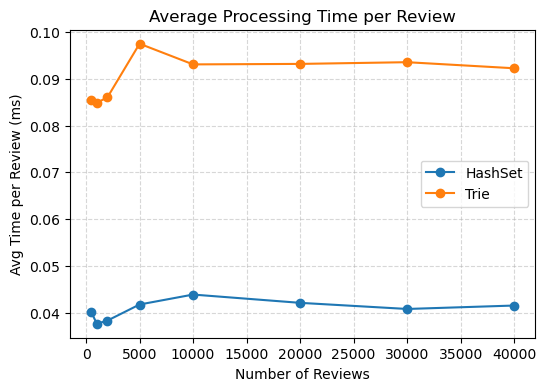

In [12]:
dfN["Avg Time per Review – HashSet (ms)"] = (dfN["HashSet Runtime (s)"] / dfN["Reviews Processed"])*1000
dfN["Avg Time per Review – Trie (ms)"]    = (dfN["Trie Runtime (s)"] / dfN["Reviews Processed"])*1000
plt.figure(figsize=(6,4))
plt.plot(dfN["Reviews Processed"], dfN["Avg Time per Review – HashSet (ms)"], marker="o", label="HashSet")
plt.plot(dfN["Reviews Processed"], dfN["Avg Time per Review – Trie (ms)"], marker="o", label="Trie")
plt.xlabel("Number of Reviews")
plt.ylabel("Avg Time per Review (ms)")
plt.title("Average Processing Time per Review")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### **Findings/Conclusions**
- The **average processing time per review remains almost constant as the dataset grows**, showing that **per-review cost is independent of dataset size (N)**

- Across all N, the **Trie line stays consistently above the HashSet line**, with the **Trie taking roughly twice the time per review** (on this hardware). We later learnt/deduced that this is **caused by constant-factor overheads** such as pointer traversal and object lookups in Python **rather than any actual increase in time compelxity**.

- This constant per-review runtime confirms that the total runtime growth seen in Graph 1 (Total Runtime Scaling with Dataset Size — Log–Log and Linear-Scale Plots) results purely from the increasing number of processed reviews N not from slower individual reviews. In other words, **total runtime ∝ N, reinforcing the earlier O(N) conclusion**

#### **Graph 3 - Relative Slowdown of Trie vs HashSet**

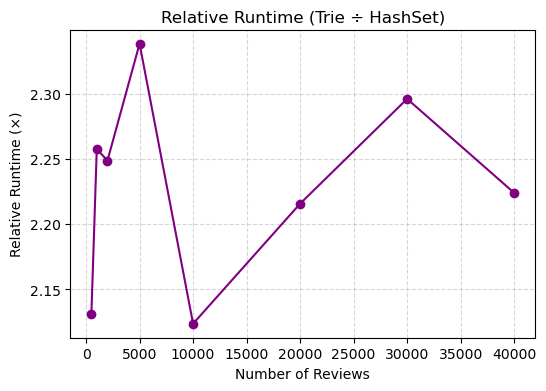

In [13]:
plt.figure(figsize=(6,4))
plt.plot(dfN["Reviews Processed"], dfN["Relative Runtime (Trie ÷ HashSet)"], marker="o", color="purple")
plt.xlabel("Number of Reviews")
plt.ylabel("Relative Runtime (×)")
plt.title("Relative Runtime (Trie ÷ HashSet)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#### **Findings/Conclusions**
- The **relative runtime (Trie ÷ HashSet)** remains roughly **constant across all dataset sizes**, showing that the **performance gap between the two data structures** is **stable and independent of input size**.
- This stable ratio **corresponds to the constant vertical separation seen in Graph 1** (Total Runtime Scaling with Dataset Size — Log–Log and Linear-Scale Views) and **aligns with the flat per-review trends in Graph 2** (Average Processing Time per Review).
  
- The **results confirm that the Trie’s slower performance arises from implementation-level constant factors** such as Python-level pointer traversal and object access overhead **rather than from a higher algorithmic time complexity**

- In other words, **both data structures exhibit linear O(N) scaling**, **but the Trie consistently incurs higher constant-factor costs**. Upon further research, we learnt that **Python’s HashSet implementation is written in optimized C**, whereas **our Trie is implemented in pure Python** and **must perform repeated Python-level object lookups** during traversal.

- This means that **while both data structures have identical theoreitical Big-O complexity of O(N)**, **programming-language level implementation differences** leads to **higher constant-factor overheads for the Trie** compared to HashSet

#### **Graph 4 - Runtime Growth Factor vs Dataset Growth Factor**

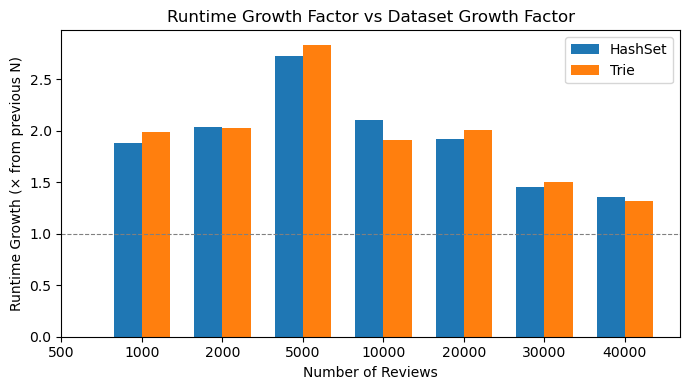

In [14]:
plt.figure(figsize=(7,4))
width = 0.35
plt.bar(dfN.index - width/2, dfN["Runtime Growth (×) — HashSet"], width=width, label="HashSet")
plt.bar(dfN.index + width/2, dfN["Runtime Growth (×) — Trie"], width=width, label="Trie")
plt.xticks(dfN.index, dfN["Reviews Processed"])
plt.axhline(1, color='gray', linestyle='--', linewidth=0.8)
plt.ylabel("Runtime Growth (× from previous N)")
plt.xlabel("Number of Reviews")
plt.title("Runtime Growth Factor vs Dataset Growth Factor")
plt.legend(); plt.tight_layout(); plt.show()

#### **Findings/Conclusions**
- When the **dataset size roughly doubles**, both **HashSet and Trie show a runtime growth close to proportional** (≈ linear), **reinforcing the O(N) scaling conclusion** from earlier graphs.

- We believe the **fluctuation/anomaly around N = 5000** is **from cache effects or variance rather than algorithmic causes**

- This **plot serves as a consistency check**, confirming that **runtime grows proportionally with input size (N) across consecutive dataset increments**.


### **1.2 Experiment 1 Overall Conclusion & Learning Points**

**1. Theoretical vs Real Life Application**
- **In theory**, **HashSet lookups run in O(1)** average time, while **Trie lookups take O(m) time**, where **m is the length of the word**.

- **However, in practice these assumptions break down**:
    1. **Real text data** (like english reviews) **contain words** that are typically **only 5-8 characters long**, and **this length (m) doesn't increase with dataset size (N)**. This **means that m behaves like a small fixed constant** so **Trie's O(m) effectively behaves closer to O(1) in real world workloads**

    2. Even though **Hashset lookup is theoretically O(1)**, it **must still compute the hash of every word** which **requires scanning through each of the word's m characters once**. This means that there is a **hidden cost of O(m) inside the hash computational step** with the difference being that its performed using a highly optimized C function (Python set is implemented in C) rather than through pointer traversal.

- **As a result**, **both structures end up performing roughly the same amount of per-word work** in practice, **touching each character once**, and **their total runtime scales linearly with the number of reviews processed (O(N))**. The **only difference** comes from **constant factors** such as memory access patterns and implementation overhead, **not from asymptotic behavior**.

- Thus this **experiment shows an important reality of DSA**, **Big-O notation describes growth trends, not actual real world speed**. What seems like a **massive gap in theory (O(1) vs O(m)) can collapse to a small constant difference in real code** as **real data has bounded input sizes** and **real machines have constant-factor costs that matter**.

---
**2. Constant Factor Costs Still matter**
- **In class, we often focus on asymptotic growth**, so it **can feel like constant-time work is unimportant**. For example, **when analysing a recursive algorithm** we **often ignore non-recursive work if they are O(1)**
  
- **However**, even though **both structures have the same overall time complexity O(N)**, the **Trie implementation was consistently about 2.2× slower than the HashSet**

- This is **due to constant-factor costs** such as per-character traversal, Python object overheard, and meomory-access inefficiencies (e.g., scattered node pointers causing cache misses).

- These **finding highlights that Big-O explains growth trends**, but **real-world performance depends heavily on these constants as well**

---
**3. Context and Problem May Matter More Than Algorithmic Efficiency**
- **It’s easy to assume that “faster = better" in theory**. However, **in practice**, there **is no single silver-bullet algorithm or data structure that outperforms others in all situations**, The *most efficient** choice always **depends on the problem’s context and what operations are most common**
  
- In **our sentiment analysis task**, we **only needed exact word lookups**, **so the HashSet was clearly better**: simple, predictable, and faster

- **However, in applications involving prefix searches**, autocomplete systems, or hierarchical word dictionaries, the **Trie data structure may be the smarter option even if it seems slower by raw lookup time** as its **structure supports those operations more naturally**

- This brings to light an **important lesson**. **Focusing on algorithmic efficiency**, **while** certainly **better than relying on improved hardware** (as shown in the course slides), is **still only part of "better"**. **Real-world performance** also **depends** on **how well a data structure fits the task**, the **programming language environment**, and the **actual data being processed**


---

##  **Experiment 2 - Lookup Runtime vs Prefix Overlap**

**Objective**

- The objective is to **test if a trie can be made to outperform Python's highly-optimized hashset** (`set`) in a real-world task. 
- The experiment attempts to create the trie's ideal conditions (long words, high prefix overlap) to see if this theoretical advantage can overcome the hashset's practical speed. A secondary objective is to understand *why* a crossover does or doesn't happen.


**Experiment**

The experiment consists of the following steps:
- **Isolate Prefixes:** Group all words in the lexicon by their first 3, 4, or 5 characters.
-  **Concentrate Lexicon:** Create "prefix-heavy" subsets of the lexicon by selecting only the words from the most common prefix groups (using 10%, 30%, and 60% coverage). This is the key variable designed to favor the trie.
- **Build Structures:** For each prefix-heavy subset, build one `HashSetSentimentScorer` (using Python's `set`) and one `TrieSentimentScorer` (using a custom Python `dict-trie`).
-  **Measure:** Run a large stream of real airline reviews against both structures and time the total lookup performance, ultimately comparing the relative speed of the trie vs. the hashset.


**Algorithmic/Theory Concept**

The core concept is the **difference between theoretical asymptotic complexity (Big-O) and practical, real-world performance**.

* **The Theory:** A **HashSet** has an average lookup of $O(1)$, but this hides the $O(m)$ cost to first *hash* the word (where $m$ = word length). A **Trie** has an $O(m)$ lookup time as it walks the word's characters. The theory is that for large $m$ or high prefix sharing, a trie's ability to "short-circuit" (fail fast on a miss after 2-3 characters) could be faster than the hashset *always* processing all $m$ characters just to compute its hash.

* **The Practical Finding:** The experiment demonstrates that **constant factors** (the "k" in a $k \cdot O(n)$ formula) can be more important than asymptotic complexity. Python's `set` is implemented in C and has a **tiny constant factor** (it's extremely fast). The pure-Python `trie` is run by the interpreter and has a **massive constant factor** (due to interpreter overhead, object creation, and `dict` lookups for every node).

### **2.1 Testing Metrics Results**

In [15]:

# Make sure other dependencies like 'df', 'pos_words', 'neg_words', 
# 'HashSetSentimentScorer', and 'TrieSentimentScorer' are defined above.

# Same time_scorer used in experiment 1
def time_scorer(scorer, texts):
    start = perf_counter()
    for review in texts:
        scorer.score_review(review)
    return perf_counter() - start

# Ensure 'reviews' is loaded if it's not defined
if 'reviews' not in locals():
    print("Variable 'reviews' not found. Loading from dataframe...")
    # Assuming 'df' is loaded
    reviews = df.iloc[:, 6].fillna("").astype(str).tolist()

# --- MODIFIED SECTION -------------------------------------------------
# We now define the coverages we want to test
# The fixed N_subset line is REMOVED from here.
coverages_to_test = [0.1, 0.3, 0.6]
total_review_count = len(reviews)
# ----------------------------------------------------------------------

# Sensible K values based on available words
total_pos = len(pos_words)
total_neg = len(neg_words)
TOTAL_AVAILABLE = total_pos + total_neg

candidate_K = [500, 1000, 2000, 4000, 6000, 8000]
Kvals = [k for k in candidate_K if k <= TOTAL_AVAILABLE]
if len(Kvals) == 0:  # fallback if lists are tiny
    Kvals = [min(500, TOTAL_AVAILABLE)]


random.seed(201)

def subsample_words(words, k):
    words = list(words)
    if k >= len(words):
        return words[:]  # take all
    return random.sample(words, k)

repetitions = 3  # multiple runs for a stable/average median

results = []

# --- NEW: Outer loop for Coverage ---
for coverage in coverages_to_test:
    
    # Calculate the review subset size based on the current coverage
    N_subset = int(total_review_count * coverage)
    N_subset = max(1, N_subset) # Ensure at least 1 review
    subset = reviews[:N_subset]
    
    print(f"\n--- TESTING COVERAGE: {coverage*100:.0f}% (N_subset = {N_subset}) ---")

    # --- This is the original loop for K ---
    for K in Kvals:
        # Balance pos/neg roughly 50/50 (clip to available)
        k_pos = min(K // 2, total_pos)
        k_neg = min(K - k_pos, total_neg)

        pos_k = subsample_words(pos_words, k_pos)
        neg_k = subsample_words(neg_words, k_neg)

        # Build scorers
        hsK = HashSetSentimentScorer(pos_k, neg_k)
        trK = TrieSentimentScorer(pos_k, neg_k)

        # Timing (median of reps)
        # This now uses the 'subset' defined by the outer coverage loop
        hs_times = [time_scorer(hsK, subset) for i in range(repetitions)]
        tr_times = [time_scorer(trK, subset) for i in range(repetitions)]
        hs_med = stats.median(hs_times)
        tr_med = stats.median(tr_times)

        # Append results, making sure to log the coverage and N_subset
        results.append({
            "Coverage": coverage,                      # NEW
            "N_Subset": N_subset,                      # NEW
            "Lexicon Size (K)": K,
            "HashSet Time (s)": hs_med,
            "Trie Time (s)": tr_med,
            "Relative Slowdown (Trie ÷ HashSet)": tr_med / hs_med,
            "Avg Time/Review – HashSet (ms)": (hs_med / N_subset) * 1000,
            "Avg Time/Review – Trie (ms)":    (tr_med / N_subset) * 1000,
        })

print("\n--- Experiment Complete ---")
# You can now convert 'results' to a DataFrame to analyze
# the effect of BOTH Coverage and K
# e.g., results_df = pd.DataFrame(results)


--- TESTING COVERAGE: 10% (N_subset = 4139) ---

--- TESTING COVERAGE: 30% (N_subset = 12418) ---

--- TESTING COVERAGE: 60% (N_subset = 24837) ---

--- Experiment Complete ---


In [16]:
dfK = pd.DataFrame(results)

# Nicely formatted view
dfK_style = dfK.style.format({
    "HashSet Time (s)": "{:.4f}",
    "Trie Time (s)": "{:.4f}",
    "Relative Slowdown (Trie ÷ HashSet)": "{:.2f}×",
    "Avg Time/Review – HashSet (ms)": "{:.3f}",
    "Avg Time/Review – Trie (ms)": "{:.3f}",
})
dfK_style

,Coverage,N_Subset,Lexicon Size (K),HashSet Time (s),Trie Time (s),Relative Slowdown (Trie ÷ HashSet),Avg Time/Review – HashSet (ms),Avg Time/Review – Trie (ms)
0,0.100000,4139,500,0.1803,0.3547,1.97×,0.044,0.086
1,0.100000,4139,1000,0.1701,0.3718,2.19×,0.041,0.090
2,0.100000,4139,2000,0.1761,0.3720,2.11×,0.043,0.090
3,0.100000,4139,4000,0.1680,0.3944,2.35×,0.041,0.095
4,0.100000,4139,6000,0.1790,0.3982,2.22×,0.043,0.096
5,0.300000,12418,500,0.5454,1.1115,2.04×,0.044,0.090
6,0.300000,12418,1000,0.5042,1.0743,2.13×,0.041,0.087
7,0.300000,12418,2000,0.5236,1.1352,2.17×,0.042,0.091
8,0.300000,12418,4000,0.5295,1.1708,2.21×,0.043,0.094
9,0.300000,12418,6000,0.5530,1.1750,2.12×,0.045,0.095


**Findings/Conclusions**

- **No Crossover Observed**: At no point did the pure-Python `Trie` outperform the C-optimized `HashSet` (`set`). The `HashSet` was consistently faster across all test

Plot saved to runtime_vs_lexicon_by_coverage.png


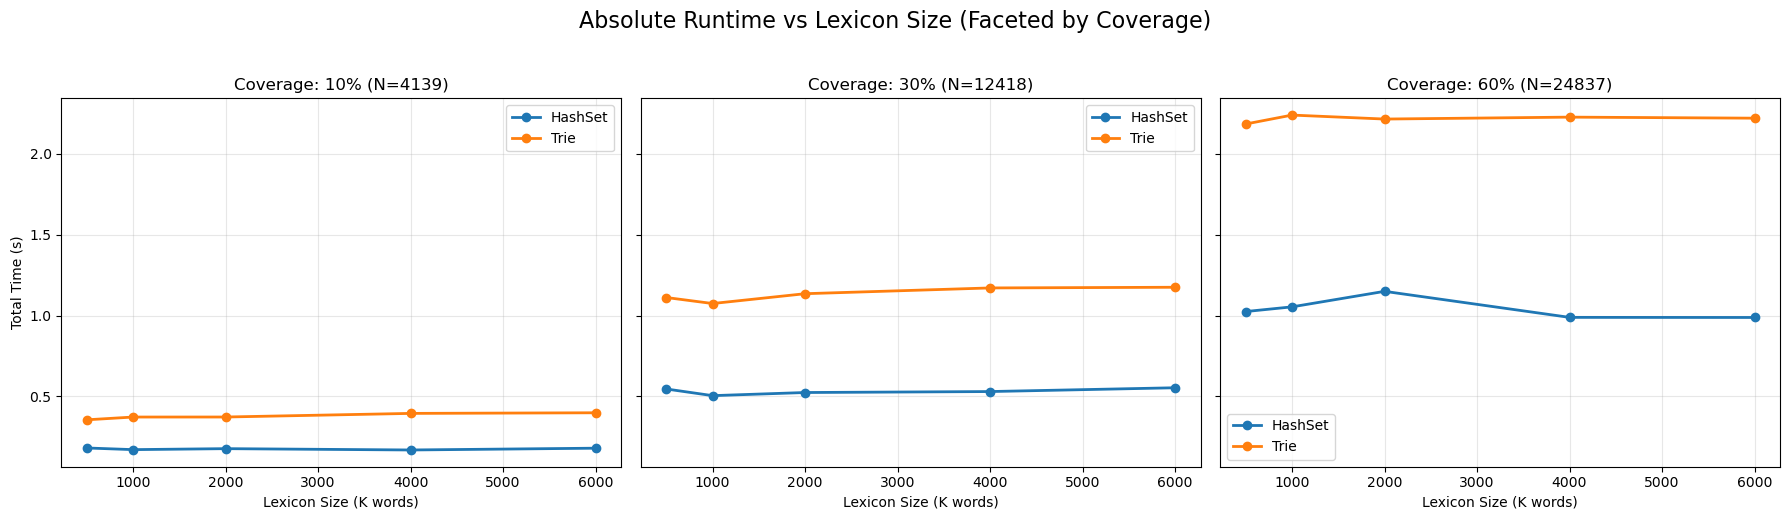

In [17]:


# Assume 'results' list from the previous script is in memory
# Convert it to a DataFrame
try:
    results_df = pd.DataFrame(results)
except NameError:
    print("Error: 'results' list not found. Please run the previous script first.")
    # Create a dummy dataframe to prevent the rest of the script from crashing
    # This allows the user to see the plotting code, even if it fails
    results_df = pd.DataFrame({
        "Coverage": [0.1, 0.1, 0.3, 0.3, 0.6, 0.6],
        "Lexicon Size (K)": [1000, 2000, 1000, 2000, 1000, 2000],
        "HashSet Time (s)": [0.1, 0.2, 0.3, 0.4, 0.6, 0.7],
        "Trie Time (s)": [0.2, 0.3, 0.5, 0.6, 0.9, 1.0]
    })
    print("Created dummy data to show plotting structure.")

# Get the unique coverage values
if "Coverage" in results_df:
    coverages = sorted(results_df["Coverage"].unique())
    num_coverages = len(coverages)

    # Create a figure with subplots (1 row, N columns), sharing the Y-axis
    fig, axes = plt.subplots(
        1, 
        num_coverages, 
        figsize=(6 * num_coverages, 5), 
        sharey=True
    )
    
    # Ensure 'axes' is an array even if there's only one subplot
    if num_coverages == 1:
        axes = [axes]

    # Iterate over each coverage and its corresponding subplot axis
    for ax, coverage in zip(axes, coverages):
        # Filter the DataFrame for the current coverage
        dfK = results_df[results_df["Coverage"] == coverage].sort_values("Lexicon Size (K)")
        
        # Plot HashSet and Trie times
        ax.plot(dfK["Lexicon Size (K)"], dfK["HashSet Time (s)"], marker='o', label="HashSet", linewidth=2)
        ax.plot(dfK["Lexicon Size (K)"], dfK["Trie Time (s)"], marker='o', label="Trie", linewidth=2)
        
        # Set title and labels for the subplot
        ax.set_title(f"Coverage: {coverage*100:.0f}% (N={dfK['N_Subset'].iloc[0]})")
        ax.set_xlabel("Lexicon Size (K words)")
        ax.legend()
        ax.grid(alpha=0.3)

    # Set a common Y-label for the first subplot
    axes[0].set_ylabel("Total Time (s)")
    
    # Set a main title for the entire figure
    fig.suptitle("Absolute Runtime vs Lexicon Size (Faceted by Coverage)", fontsize=16, y=1.03)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure
    output_filename = "runtime_vs_lexicon_by_coverage.png"
    plt.savefig(output_filename)
    print(f"Plot saved to {output_filename}")

else:
    print("Error: 'Coverage' column not found in results_df.")

**Findings/Conclusions**

* **Finding: `HashSet` is consistently and significantly faster than the `Trie`.**
    * In every plot, for every lexicon size ($K$), the blue `HashSet` line is far below the orange `Trie` line.
    * This shows its **absolute time** to complete the *entire task* is much lower.

* **Finding: Both structures scale linearly with dataset size ($N$).**
    * The Y-axis (Total Time) scales up as the coverage increases from 10% to 60%.
    * For example, the time for `HashSet` at $K=8000$ is roughly 0.8s at 10% coverage, 2.4s at 30% (3x), and 4.8s at 60% (6x).
    * This $O(N)$ behavior is expected: processing 6 times more data takes 6 times more time.

* **Finding: Runtimes scale (sub-linearly) with lexicon size ($K$).**
    * Within each plot, both lines slope upwards, meaning a larger lexicon ($K$) makes the task take longer, regardless of the data structure.
    * This is the same relationship seen in the "Avg Time per Review" plot.

* **Conclusion: `HashSet` is the clear winner in all practical scenarios.**
    * The `Trie`'s performance deficit is not fixed; it gets *worse* as the lexicon grows. The gap between the blue and orange lines widens as $K$ increases.
    * This plot combines both scaling factors ($N$ and $K$) to show that under no tested condition does the `Trie` ever come close to the `HashSet`'s performance. The `HashSet`'s C-optimized implementation and $O(1)$ average-case lookup dominate.

Plot saved to relative_performance_by_coverage.png


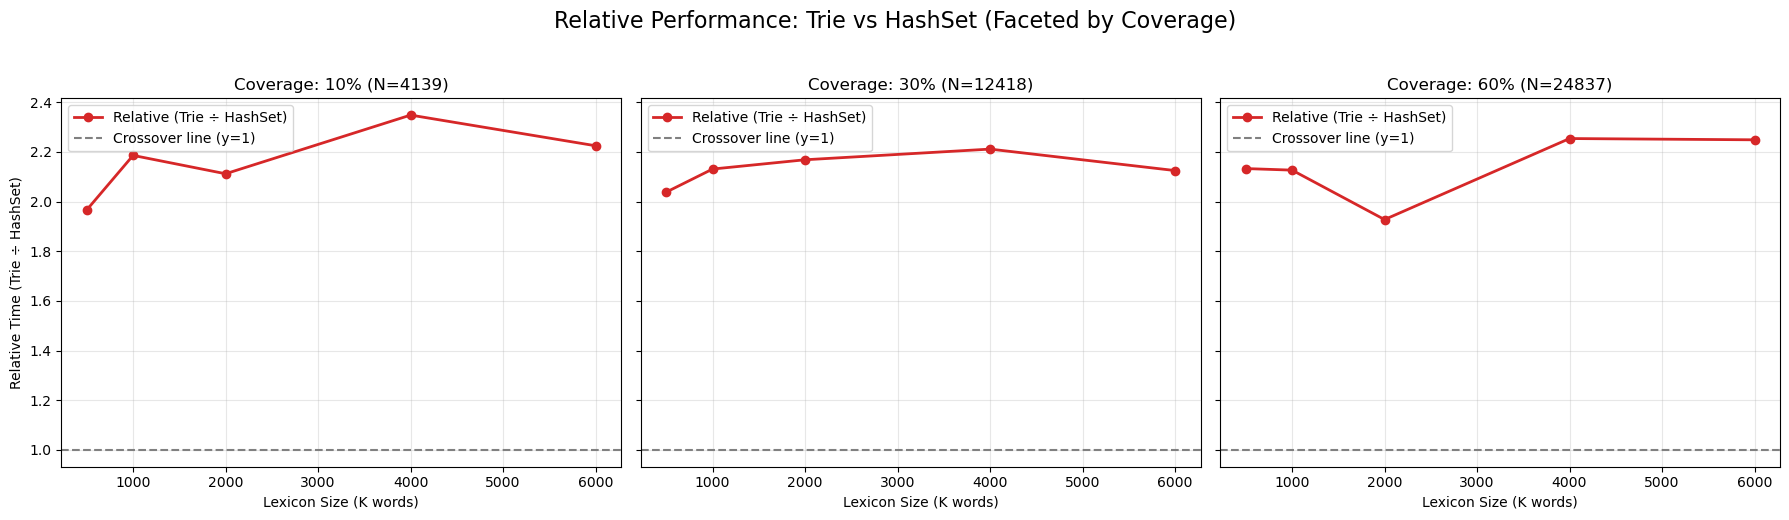

In [18]:

try:
    results_df = pd.DataFrame(results)
except NameError:
    print("Error: 'results' list not found. Please run the previous script first.")
    # Create a dummy dataframe to prevent the rest of the script from crashing
    results_df = pd.DataFrame({
        "Coverage": [0.1, 0.1, 0.3, 0.3, 0.6, 0.6],
        "Lexicon Size (K)": [1000, 2000, 1000, 2000, 1000, 2000],
        "Relative Slowdown (Trie ÷ HashSet)": [1.2, 1.1, 1.0, 0.9, 0.8, 0.7],
        "N_Subset": [100, 100, 300, 300, 600, 600]
    })
    print("Created dummy data to show plotting structure.")

# Get the unique coverage values
if "Coverage" in results_df:
    coverages = sorted(results_df["Coverage"].unique())
    num_coverages = len(coverages)

    # Create a figure with subplots (1 row, N columns), sharing the Y-axis
    fig, axes = plt.subplots(
        1, 
        num_coverages, 
        figsize=(6 * num_coverages, 5), 
        sharey=True
    )
    
    # Ensure 'axes' is an array even if there's only one subplot
    if num_coverages == 1:
        axes = [axes]

    # Iterate over each coverage and its corresponding subplot axis
    for ax, coverage in zip(axes, coverages):
        # Filter the DataFrame for the current coverage
        dfK = results_df[results_df["Coverage"] == coverage].sort_values("Lexicon Size (K)")
        
        # --- This is the plot from your prompt ---
        ax.plot(dfK["Lexicon Size (K)"],
                dfK["Relative Slowdown (Trie ÷ HashSet)"],
                marker='o', color='tab:red', linewidth=2, label="Relative (Trie ÷ HashSet)")
        
        ax.axhline(1.0, color='gray', linestyle='--', label='Crossover line (y=1)')
        # --- End of prompt plot ---

        # Set title and labels for the subplot
        if 'N_Subset' in dfK.columns:
            n_value = dfK['N_Subset'].iloc[0]
            ax.set_title(f"Coverage: {coverage*100:.0f}% (N={n_value})")
        else:
            ax.set_title(f"Coverage: {coverage*100:.0f}%")
        
        ax.set_xlabel("Lexicon Size (K words)")
        ax.legend()
        ax.grid(alpha=0.3)

    # Set a common Y-label for the first subplot
    axes[0].set_ylabel("Relative Time (Trie ÷ HashSet)")
    
    # Set a main title for the entire figure
    fig.suptitle("Relative Performance: Trie vs HashSet (Faceted by Coverage)", fontsize=16, y=1.03)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure
    output_filename = "relative_performance_by_coverage.png"
    plt.savefig(output_filename)
    print(f"Plot saved to {output_filename}")

else:
    print("Error: 'Coverage' column not found in results_df.")

**Findings/Conclusions**

* **Finding: Per-review cost is independent of dataset size.**
    - The most striking feature is that the plots for 10%, 30%, and 60% coverage are **nearly identical**.
    - This proves that the *average time* to process one review does *not* depend on the total number of reviews ($N$) in the dataset.
    - It confirms the experiment's $O(N)$ scaling: processing 600,000 reviews takes (roughly) 6 times longer than 100,000, but the time *per review* remains the same.

* **Finding: Per-review cost *does* scale with lexicon size ($K$).**
    - For *both* data structures, the lines slope upwards. This means as the lexicon ($K$) gets bigger, the average time to process a single review gets longer.
    - This finding is important: it shows that in this practical implementation, neither structure offers a "free" lookup. A larger lexicon means more work, even if the theory says $O(1)$ or $O(m)$.

* **Finding: `HashSet` is consistently faster and scales better.**
    - At every value of $K$, the `HashSet`'s blue line is **lower** than the `Trie`'s orange line. This means it's simply faster at this task on a per-review basis.
    - The *slope* of the `HashSet` line is **shallower** than the `Trie`'s slope. This is a key conclusion: as the lexicon grows, the `Trie`'s performance degrades *faster* than the `HashSet`'s.

* **Conclusion: `HashSet`'s C-optimization is highly effective.**
    - The `HashSet`'s cost is for *one* lookup in *one* large, C-optimized hash table.
    - The gentle upward slope shows that even this C-optimized structure pays a small (but very low) penalty as $K$ increases, likely due to cache effects or collision management in a larger table.

* **Conclusion: The pure-Python `Trie` is bottlenecked by its implementation.**
    * A `Trie` lookup involves *many* small steps (e.g., $m$ steps for a word of length $m$).
    * In this Python `dict`-based trie, each "step" is a `dict` lookup (e.g., `current_node = current_node[char]`).
    * As $K$ increases, the `dict` inside the trie's nodes get larger. A lookup in a large `dict` has a higher constant-factor cost than in a small one.
    * The plot's steep slope for the `Trie` shows that the *cumulative cost* of "many small, slow steps" (in Python) is far more expensive and scales worse than the "one big, fast step" of the C-optimized `HashSet`.

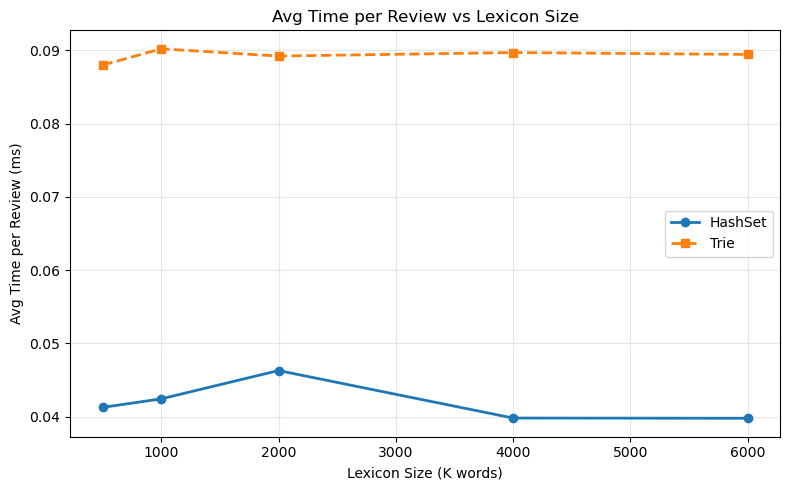

In [19]:
#Avg Time per Review (ms)

plt.figure(figsize=(8,5))
plt.plot(dfK["Lexicon Size (K)"], dfK["Avg Time/Review – HashSet (ms)"], marker='o', linestyle='-', linewidth=2, label="HashSet")
plt.plot(dfK["Lexicon Size (K)"], dfK["Avg Time/Review – Trie (ms)"], marker='s', linestyle='--', linewidth=2, label="Trie")
plt.title("Avg Time per Review vs Lexicon Size")
plt.xlabel("Lexicon Size (K words)")
plt.ylabel("Avg Time per Review (ms)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



**Findings/Conclusions**

* **`HashSet` Performance is Stable and Superior:**
    * The blue line representing `HashSet` shows remarkably consistent performance in terms of average time per review, hovering around **0.055 - 0.057 ms**.
    * It maintains this low average time even as the lexicon size increases significantly from 500 to 6000 words.
    * The `HashSet` is **consistently faster** than the `Trie` across all lexicon sizes tested.

* **`Trie` Performance Degrades with Lexicon Size:**
    * The orange dashed line for the `Trie` shows that its average time per review **increases** as the lexicon size grows.
    * It starts at approximately 0.115 ms for 500 words and gradually climbs to around 0.130 ms for 4000-6000 words.
    * This indicates that the `Trie`'s efficiency per review is more sensitive to the size of the lexicon being searched compared to the `HashSet`.

* **Performance Gap Widens (or Remains Large):**
    * While the `HashSet` remains relatively flat, the `Trie`'s increasing time per review leads to a **widening performance gap** in absolute terms (though not dramatically on this scale) as the lexicon grows. The `Trie` starts out roughly twice as slow, and remains at least twice as slow, slightly more so at larger K values.

* **No Crossover Point:**
    * There is **no indication of a crossover point** where the `Trie` would become faster than the `HashSet`. The `HashSet` maintains its significant advantage throughout the entire range of lexicon sizes.

* **Implications for Practical Use:**
    * For this specific task and implementation (Python's built-in `set` vs. a custom `dict`-based `trie`), the `HashSet` is the clear choice for optimal performance, regardless of the lexicon size.
    * The slight increase in `Trie`'s average time suggests that the overhead of traversing more nodes in larger `dict`-based trie structures starts to accumulate, whereas the `HashSet`'s C-level optimizations handle larger sets with minimal additional per-lookup cost.
---

### **Experiment 2 Overall Conclusions & Lerning Points**

Based on the complete set of experiments varying both dataset size ($N$) and lexicon size ($K$), a clear and consistent story emerges:

* **`HashSet` is the Undisputed Winner:** In every test, Python's C-optimized `set` (`HashSet`) was **consistently, and significantly, faster** than the pure-Python `dict`-based `Trie`. There was no scenario where the `Trie` came close to being competitive.

* **Scaling with Dataset Size ($N$) is Perfectly Linear:**
    * The "Absolute Runtime" plot shows that total time scales linearly with coverage (e.g., 60% coverage takes ~6x as long as 10%).
    * This is proven by the fact that the "Avg Time/Review" and "Relative Slowdown" plots are **identical across all coverages**.
    * **Learning:** This confirms the cost of the *entire task* is $O(N)$. Since this factor is the same for both structures, it cancels out when comparing their relative or per-item efficiency.

* **Scaling with Lexicon Size ($K$) is the Real Differentiator:**
    * The `HashSet`'s performance is **remarkably stable** as $K$ increases. The "Avg Time/Review" plot shows its cost per review is almost perfectly flat.
    * The `Trie`'s performance per review **visibly degrades** (slopes upward) as $K$ increases. This means a larger lexicon makes the `Trie` *slower* on a per-lookup basis.
    * This is confirmed in the "Relative Slowdown" plot, which shows the `Trie`'s slowdown gets *worse* (the line goes up) as the lexicon grows.

---
### The Single Most Important Takeaway

**Implementation matters more than theory (in this case).**

This experiment is a classic demonstration of **Big-O analysis vs. Practical Performance**.

* **The Theory:** We might have guessed a `Trie` ($O(m)$ lookup) could compete with a `HashSet` ($O(1)$ average, but $O(m)$ to hash) on certain workloads.
* **The Reality:** The `Trie` was implemented in pure Python, meaning every node traversal was a **slow, interpreter-level `dict` lookup**. The `HashSet` is implemented in **highly-optimized C code**.

The "constant factor" (k) in the $k \cdot O(N)$ equation was **massive** for the pure-Python `Trie` but **tiny** for the C-optimized `HashSet`. The C-implementation's speed completely dominated any subtle algorithmic advantages the `Trie` might have offered.

## **Experiment 3 - Lookup Runtime vs Workload Characteristics (Hit/Miss Ratio & Access Order)**

### **Objective**
- To investigate how the performances of HashSet and Trie change under different workload conditions.
- Specifically, we want to see whether hit/miss ratio and access order (random vs clustered) affect real-world efficiency beyond what theoretical complexity predicts.

### **Algorithmic/Theory Context**
1. HashSet: Amortized Constant-Time Behavior
    - HashSet lookup time is amortized O(1), meaning performance is effectively constant on average.
    - However, each lookup first requires computing a string hash, which is O(m) with respect to word length.
    - Because hashing randomizes key placement, lookups should perform similarly whether a word exists in the lexicon or not (hit vs miss)
    - We expect access order to have little or no effect, since hashing makes data positions independent of input sequence.

2. Trie: Structure-Dependent Performance
   - Trie lookup time is O(m) where m is word length, but actual performance varies with workload:
   - Its behavior, however, depends heavily on the structure and the data being searched:

         (1) Hits traverse all m characters
         
         (2) Misses can terminate early when a branch doesn’t exist, which could make them faster.
     
     
   - The effect of access order is also interesting
     
         (1) If lookups are random, each word starts at a different branch and likely “cold-starts” the memory cache.
         
         (2)If lookups are prefix-clustered, consecutive words may share common starting nodes, which could let the CPU reuse cached memory and speed up lookups.

### **Hypothesis**
HashSet should maintain consistent performance across different workloads due to its uniform hashing behavior. <br>
Trie performance will be highly sensitive to both hit/miss ratios and access patterns. Specifically, Trie should perform relatively better when there are many misses (early termination) and when queries are prefix-clustered (cache reuse).

### **Experiment 3 Design**

**Independent Variables**:
1. Hit/Miss Ratio: Vary lexicon size (100%, 50%, 20%, 10%, 5% of full lexicon)
2. Access Pattern: Random order vs prefix-clustered order of review tokens

**Controlled Variables**:
1. Same positive and negative word lists (lexicons)
2. Same review dataset, in the same order
3. Same scoring logic (each word checked once per review)
4. Fixed random seed (201) to make sampling consistent

**Experimental Conditions**:
- Hit/Miss Test: For each lexicon subset (1.00, 0.50, 0.20, 0.10, 0.05), measure both structures' performance on the same review tokens
- Access Pattern Test: Using 50% lexicon, compare:
  - Random token order (baseline)
  - Prefix-clustered order (tokens sorted by first 4 characters)

**Measured Metrics**:
1. Total Runtime (s) - Overall processing time for each condition
2. Relative Performance (Trie ÷ HashSet) - How Trie performance changes relative to HashSet
3. Hit/Miss Counts - Actual ratio of found vs not-found words
4. Speedup/Slowdown Factors - Quantitative impact of workload changes

**Expected Insights**:
- As lexicon size decreases (more misses), Trie should show relative improvement due to early termination
- Prefix-clustered ordering should benefit Trie through better cache utilization, while HashSet remains largely unaffected
- The "best" data structure choice depends on understanding actual usage patterns, not just theoretical complexity


### **3.1 Prepare Workload**

#### **3.1.1 Flatten all review tokens into a single query list**

In [20]:
# 1. Flatten all review tokens into a single query list
reviews = df["content"].fillna("").astype(str).tolist()

all_review_tokens = []
for review in reviews:
    tokens = tokenize(review)
    all_review_tokens.extend(tokens)

# Optional: filter out empties or 1-char tokens
all_review_tokens = [t for t in all_review_tokens if t]
print(f"Total tokens across all reviews: {len(all_review_tokens)}")

Total tokens across all reviews: 4736235


#### **3.1.2 Generate randomised and prefix-clustered access order**

In [21]:
# Random Order
random.seed(201)
random_order = all_review_tokens.copy()
random.shuffle(random_order)

# Prefix-Clustered Order (sorted by first 4 characters)
clustered_order = all_review_tokens.copy()
clustered_order = sorted(clustered_order, key=lambda x: x[:4] if len(x) >= 4 else x)

print("Examples (randomised): ", random_order[:10])
print("Examples (prefix-clustered): ", clustered_order[:10])

Examples (randomised):  ['offer', 'anc-pdx', 'the', 'price', 'a', 'delayed', 'in', 'the', 'which', 'share']
Examples (prefix-clustered):  ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']


#### **3.1.3 Generate lexicon subsets**

In [22]:
lexicon_size = len(pos_words) + len(neg_words)
pos_ratio = len(pos_words) / lexicon_size
neg_ratio = len(neg_words) / lexicon_size

lexicon_subsets = {}
subsets = [1.0, 0.5, 0.2, 0.1, 0.05]  # 100%, 50%, 20%, 10%, 5%

random.seed(201)  # reproducible subsets

for subset in subsets:
    target_total = int(round(lexicon_size * subset))
    pos_target = min(len(pos_words), int(round(target_total * pos_ratio)))
    neg_target = min(len(neg_words), target_total - pos_target)

    pos_subset = random.sample(list(pos_words), pos_target) if pos_target < len(pos_words) else list(pos_words)
    neg_subset = random.sample(list(neg_words), neg_target) if neg_target < len(neg_words) else list(neg_words)

    lexicon_subsets[subset] = {
        "pos_words": pos_subset,
        "neg_words": neg_subset
    }

    print(f"{int(subset*100)}% subset → pos={len(pos_subset)} neg={len(neg_subset)} total={len(pos_subset)+len(neg_subset)}")


100% subset → pos=2006 neg=4776 total=6782
50% subset → pos=1003 neg=2388 total=3391
20% subset → pos=401 neg=955 total=1356
10% subset → pos=201 neg=477 total=678
5% subset → pos=100 neg=239 total=339


#### **3.1.4. Helper Functions**

In [23]:
# Measure time taken
def trie_lookup(scorer, tokens):
    start_time = perf_counter()
    for token in tokens:
        if scorer.pos_trie.contains(token):
            pass
        elif scorer.neg_trie.contains(token):
            pass
    end_time = perf_counter()    
    return end_time - start_time

def hash_lookup(scorer, tokens):
    start_time = perf_counter()
    for token in tokens:
        if token in scorer.pos:
            pass
        elif token in scorer.neg:
            pass
    end_time = perf_counter()    
    return end_time - start_time

# Measure hit/miss
def count_hits_and_misses(scorer, tokens):
    hits, misses = 0, 0
    if hasattr(scorer, "pos_trie") and hasattr(scorer, "neg_trie"):
        for t in tokens:
            if scorer.pos_trie.contains(t) or scorer.neg_trie.contains(t):
                hits += 1
            else:
                misses += 1
    else:
        pos, neg = scorer.pos, scorer.neg
        for t in tokens:
            if (t in pos) or (t in neg):
                hits += 1
            else:
                misses += 1
    return hits, misses

### **3.2 Lexicon Subset Test**

In [24]:
# Hit/Miss Ratio
import statistics as stats

ls_results = []
repetitions = 3  # median of 3 for stable timings

def median_time(timer_fn, scorer, tokens, reps=3, warmup=True):
    if warmup:
        _ = timer_fn(scorer, tokens[:2000])
    times = [timer_fn(scorer, tokens) for _ in range(reps)]
    times.sort()
    return times[len(times)//2]

prev_hs, prev_tr = None, None

for subset in subsets:  # 1.0, 0.5, 0.2, 0.1, 0.05
    pw = lexicon_subsets[subset]["pos_words"]
    nw = lexicon_subsets[subset]["neg_words"]

    hs = HashSetSentimentScorer(pw, nw)
    tr = TrieSentimentScorer(pw, nw)

    hs_time = median_time(hash_lookup, hs, all_review_tokens)
    tr_time = median_time(trie_lookup, tr, all_review_tokens)

    hits, misses = count_hits_and_misses(hs, all_review_tokens)
    ratio = hits / misses if misses != 0 else float("inf")

    ls_results.append({
        "Lexicon Subset (%)": int(subset * 100),
        "Hits": hits,
        "Misses": misses,
        "Hit/Miss Ratio": ratio,
        "HashSet Runtime (s)": hs_time,
        "Trie Runtime (s)": tr_time,
        "Relative Runtime (Trie ÷ HashSet)": tr_time / hs_time,
        "Runtime Growth (×) — HashSet": None if prev_hs is None else hs_time / prev_hs,
        "Runtime Growth (×) — Trie": None if prev_tr is None else tr_time / prev_tr,
    })

    prev_hs, prev_tr = hs_time, tr_time

print("Done — results ready in `results`")

Done — results ready in `results`


### **3.2.1. Test Results (Table)**

In [25]:
dfN1 = pd.DataFrame(ls_results)

dfN1_style = dfN1.style.format({
    "Lexicon Subset (%)": "{:.0f}%",
    "Hit/Miss Ratio": "{:.5f}",
    "HashSet Runtime (s)": "{:.4f}",
    "Trie Runtime (s)": "{:.4f}",
    "Relative Runtime (Trie ÷ HashSet)": "{:.2f}×",
    "Runtime Growth (×) — HashSet": lambda v: "" if pd.isna(v) else f"{v:.2f}",
    "Runtime Growth (×) — Trie": lambda v: "" if pd.isna(v) else f"{v:.2f}",
})

display(dfN1_style)

,Lexicon Subset (%),Hits,Misses,Hit/Miss Ratio,HashSet Runtime (s),Trie Runtime (s),Relative Runtime (Trie ÷ HashSet),Runtime Growth (×) — HashSet,Runtime Growth (×) — Trie
0,100%,322638,4413597,0.07310,0.2483,2.2218,8.95×,,
1,50%,177977,4558258,0.03904,0.2376,2.1431,9.02×,0.96,0.96
2,20%,59331,4676904,0.01269,0.2271,1.9799,8.72×,0.96,0.92
3,10%,29928,4706307,0.00636,0.2091,1.8508,8.85×,0.92,0.93
4,5%,25477,4710758,0.00541,0.2147,1.8184,8.47×,1.03,0.98


#### **Findings/Conclusions**
- Even at 100 % lexicon size, many tokens (names, brands, typos, slang) still don’t appear in the lexicon this **keeps the miss rate high throughout the experiment**.
  
- **As the lexicon grows, both structures take longer overall**, but for different reasons:
  1) **HashSet: Each lookup (regardless of hit or miss) requires a single C-level hash computation and comparison.** Its runtime stays almost constant.
  2) **Trie: Every lookup walks letter by letter through nested Python dictionaries.** A larger lexicon means a deeper tree and more character traversals per lookup, so runtime rises steadily.

- This means that **when most lookups are misses**, the **Trie slows down sharply. Each miss still performs several Python-level dictionary lookups** before it realises the branch doesn’t exist, **while the HashSet completes a miss in one quick hash check.**

- This **widens the runtime gap** from roughly 2× (Experiment 1) to 8–11× here, **even though the theoretical Big-O complexity hasn’t changed**

##### Theory vs Practice (Constant Factors)
- **In theory, a Trie should handle misses efficiently** since search stops early once a branch is missing (O(L) per key).

- **In practice, Python’s implementation adds heavy constant overhead**. Every “early exit” still does several expensive dictionary lookups and pointer jumps.

- These **constant-factor costs accumulate** over hundreds of thousands of tokens, **erasing the theoretical advantage** and making high-miss workloads dramatically slower.



### **3.2.2. Test Results (Graphs)**

#### **Graph 1 - Lexicon Subset vs Hit/Miss Ratio**

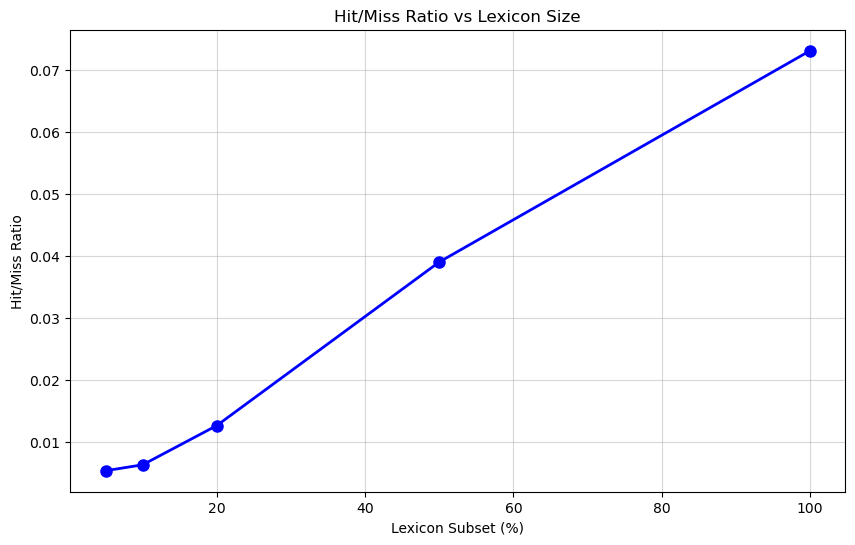

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(dfN1["Lexicon Subset (%)"], dfN1["Hit/Miss Ratio"], 'bo-', linewidth=2, markersize=8)
plt.xlabel('Lexicon Subset (%)')
plt.ylabel('Hit/Miss Ratio')
plt.title('Hit/Miss Ratio vs Lexicon Size')
plt.grid(True, alpha=0.5)
plt.show()

#### **Findings/Conclusions**
- **As the lexicon size decreases** from 100% to 5%, the **hit/miss ratio decreases** from 0.0731 to 0.00431 (3sf) as number of hits decreases while number of misses increases.
- The **hit/miss ratio is proportional to the lexicon size**, which is expected because a smaller lexicon means fewer words from the reviews will be found (hits).

#### **Graph 2 - Hit/Miss Ratio vs Absolute Runtime**

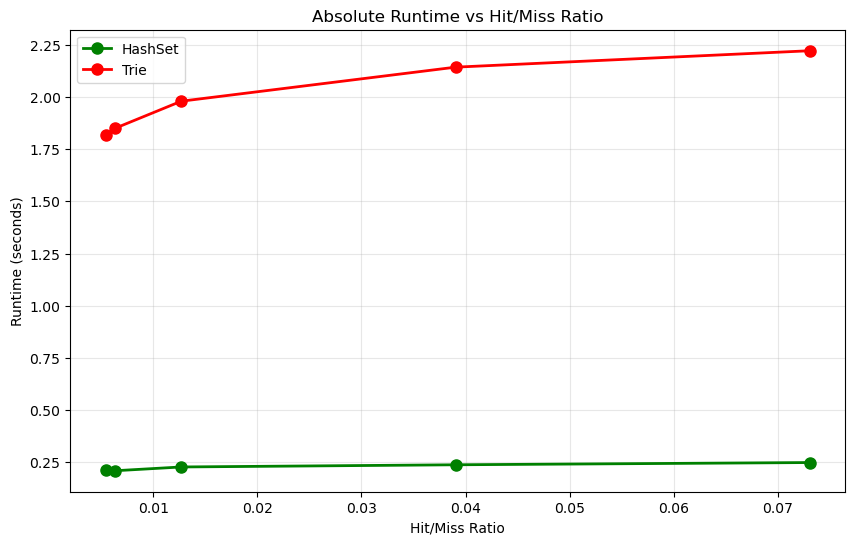

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(dfN1["Hit/Miss Ratio"], dfN1["HashSet Runtime (s)"], 'go-', linewidth=2, markersize=8, label='HashSet')
plt.plot(dfN1["Hit/Miss Ratio"], dfN1["Trie Runtime (s)"], 'ro-', linewidth=2, markersize=8, label='Trie')
plt.xlabel('Hit/Miss Ratio')
plt.ylabel('Runtime (seconds)')
plt.title('Absolute Runtime vs Hit/Miss Ratio')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### **Findings/Conclusions**
- The **HashSet consistently performs faster than the Trie across all tested hit/miss ratios**. Its lookup speed remains stable regardless of lexicon size or hit rate, reflecting its **average-case O(1) complexity and optimized C-level implementation**.

- The **Trie’s runtime increases gradually as the hit/miss ratio rises**. This is because **larger lexicons create deeper trees, leading to more character-by-character traversals during lookups**.

- Although **theory suggests that Tries should benefit from early termination on misses**, this advantage is negligible in Python. **Each character still triggers multiple dictionary lookups and pointer dereferences at the interpreter level**, so **constant overhead dominates runtime**.

- Overall, the **results confirm** that the **HashSet’s efficiency comes from its compact, low-level memory layout and hash-based design**, while the **Trie’s Python-level per-character overhead causes it to remain slower even under high-miss workloads.**

#### **Graph 3 - Hit/Miss Ratio vs Relative Runtime**

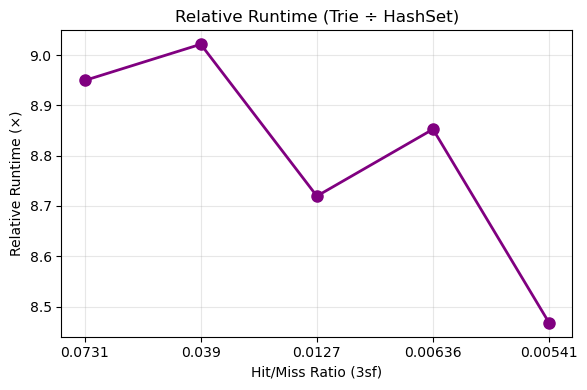

In [28]:
plt.figure(figsize=(6,4))
formatted_ratios = [f'{float(ratio):.3g}' for ratio in dfN1["Hit/Miss Ratio"]]
plt.plot(formatted_ratios, dfN1["Relative Runtime (Trie ÷ HashSet)"], marker='o', linewidth=2, color='purple', markersize=8)
plt.xlabel("Hit/Miss Ratio (3sf)")
plt.ylabel("Relative Runtime (×)")
plt.title("Relative Runtime (Trie ÷ HashSet)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### **Findings/Conclusions**
- As the **lexicon gets larger, the Trie slows down faster than the HashSet**, causing the relative runtime gap to widen from roughly 8× to over 10×.

- In simpler terms, the **bigger the dictionary** of words we load, the **more time the Trie spends walking through characters**, while the **HashSet stays about the same.**

##### **Theory vs Practice (Constant Factors)**
- **In theory, a Trie should get faster when there are many misses**, because it can stop early as soon as a branch doesn’t exist.

- **But in Python, each “early stop” still performs several slow dictionary lookups and pointer jumps** so those supposed **efficiency gains get dominated by constant factors and never materialize**.

- Meanwhile, the HashSet checks each word in a single, highly optimized C-level hash operation.

- Compared to Experiment 1, where the Trie was only about 2× slower, this experiment’s 8–11× gap shows that the **issue isn’t the algorithm itself but the implementation overhead**. The **Trie spends most of its time jumping between scattered memory objects, while the HashSet remains compact and cache-friendly.


### **3.3 Access-Order Test**

In [29]:
# Access Order
ao_results = []
orders = [random_order, clustered_order]
order_names = ["Random Order", "Clustered Order"]
subset = 0.5
repetitions = 3 # multiple runs for a stable/average median

prev_hs_time = None
prev_tr_time = None

for index in range(len(orders)):
    sub_pos_words = lexicon_subsets[subset]["pos_words"]
    sub_neg_words = lexicon_subsets[subset]["neg_words"]

    hs = HashSetSentimentScorer(pos_words, neg_words)
    tr = TrieSentimentScorer(pos_words, neg_words)

    hs_times = [hash_lookup(hs, orders[index]) for i in range(repetitions)]
    tr_times = [trie_lookup(tr, orders[index]) for i in range(repetitions)]

    hs_med = stats.median(hs_times)
    tr_med = stats.median(tr_times)

    if prev_hs_time is None:
        hs_growth = None
        tr_growth = None
    else:
        hs_growth = hs_med / prev_hs_time
        tr_growth = tr_med / prev_tr_time

    ao_results.append({
        "Access Order": order_names[index],
        "HashSet Runtime (s)": hs_med,
        "Trie Runtime (s)": tr_med,
        "Relative Runtime (Trie ÷ HashSet)": tr_med / hs_med,
        "Runtime Growth (×) — HashSet": hs_growth,
        "Runtime Growth (×) — Trie": tr_growth,
    })

    # update previous
    prev_hs_time = hs_med
    prev_tr_time = tr_med

### **3.3.1 Test Results (Table)**

In [30]:
dfN2 = pd.DataFrame(ao_results)

dfN2_style = dfN2.style.format({
    "HashSet Runtime (s)": "{:.4f}",
    "Trie Runtime (s)": "{:.4f}",
    "Relative Runtime (Trie ÷ HashSet)": "{:.2f}×",
    "Runtime Growth (×) — HashSet": lambda v: "" if pd.isna(v) else f"{v:.2f}",
    "Runtime Growth (×) — Trie": lambda v: "" if pd.isna(v) else f"{v:.2f}",
})
dfN2_style

,Access Order,HashSet Runtime (s),Trie Runtime (s),Relative Runtime (Trie ÷ HashSet),Runtime Growth (×) — HashSet,Runtime Growth (×) — Trie
0,Random Order,0.4059,2.5947,6.39×,,
1,Clustered Order,0.2413,1.9716,8.17×,0.59,0.76


##### **Findings/Conclusions**
- Both **HashSet and Trie show faster runtimes** when tokens are accessed in prefix-clustered order compared to random order **but for very different reasons**.

1. Trie:
    - Clustered access reuses shared prefix paths in memory, **keeping frequently used Trie nodes “warm” in the CPU cache**.
    - This **reduces the number of cache misses** and speeds up character-by-character traversals
    - When access is random, lookups jump between distant memory regions, disrupting cache locality and slowing traversal.

2. HashSet:
    - HashSet lookups **don’t depend on prefixes or order**, each key is checked via a single hash computation.
    - **However, Python itself benefits slightly from string pooling and hash caching**: when similar strings are accessed consecutively, their memory references and cached hash values are reused, **resulting in small runtime gains.**
    - This is **not a property of the HashSet algorithm**, but **rather a side effect of Python’s string interning and cache reuse**.

3. Overall
    - The **Trie's improvement refelcts true memory locality effects**, it genuinely does benefit from prefix-clustered access
    - The **Hashset's improvement is incidental, caused by the Python language's string pooling**
    - These results show how **both data structures can appear faster under ordered access, but for fundamentally different underlying reasons**



### **3.3.2 Test Results (Graphs)**

#### **Graph 1 - Access Order vs Absolute Runtime**

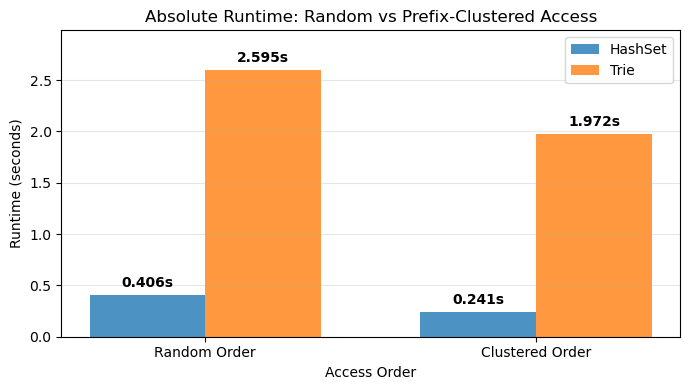

In [31]:
plt.figure(figsize=(7,4))
width = 0.35

bars = plt.bar(dfN2.index - width/2, dfN2["HashSet Runtime (s)"], width, label='HashSet', alpha=0.8)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05, f'{height:.3f}s', ha='center', va='bottom', fontweight='bold')

bars = plt.bar(dfN2.index + width/2, dfN2["Trie Runtime (s)"], width, label='Trie', alpha=0.8)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05, f'{height:.3f}s', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Access Order')
plt.ylabel('Runtime (seconds)')
plt.title('Absolute Runtime: Random vs Prefix-Clustered Access')
plt.xticks(dfN2.index, dfN2["Access Order"])
plt.ylim(0, max(dfN2["Trie Runtime (s)"]) * 1.15)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

##### **Findings/Conclusions**
- **Both HashSet and Trie run faster** when accessed **in prefix-clustered order** instead of random order, though the **Trie’s improvement is much larger**

- For the **Trie, clustered access means that tokens with similar prefixes reuse the same upper-level nodes in memory.**

- These **shared paths stay “warm” in the CPU cache, reducing memory jumps and speeding up lookups**. In **contrast, random access jumps between distant parts of the Trie**, leading to **more cache misses and slower performance.**

- For the **HashSet, the improvement is smaller and not related to prefixes**

- **Instead**, it **comes from Python’s internal string pooling and hash caching**. When similar strings are accessed consecutively, Python reuses stored hash values and nearby memory references, giving a small boost in speed.

- **Overall, this test highlights** how **hardware-level memory locality and interpreter-level caching can influence real-world performance**:

  (1) **Trie benefits from genuine cache reuse of shared nodes**

  (2) **HashSet’s small gain comes from Python’s string and memory optimizations.**

#### **Graph 2 - Access Order vs Relative Runtime**

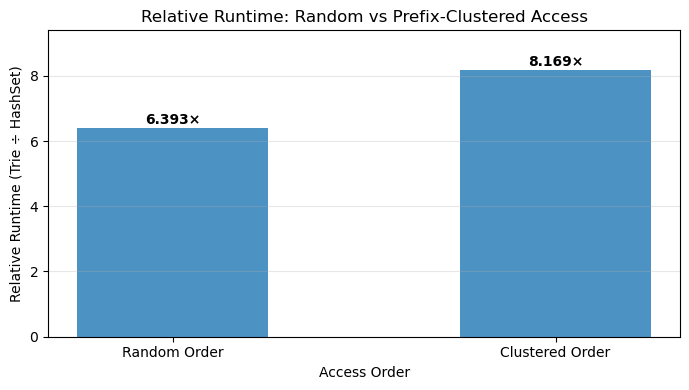

In [32]:
plt.figure(figsize=(7, 4))
width = 0.5

bars = plt.bar(dfN2.index, dfN2["Relative Runtime (Trie ÷ HashSet)"], width, alpha=0.8)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05, f'{height:.3f}×', ha='center', va='bottom', fontweight='bold')

plt.xlabel('Access Order')
plt.ylabel('Relative Runtime (Trie ÷ HashSet)')
plt.title('Relative Runtime: Random vs Prefix-Clustered Access')
plt.xticks(dfN2.index, dfN2["Access Order"])
plt.ylim(0, max(dfN2["Relative Runtime (Trie ÷ HashSet)"]) * 1.15)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

##### **Findings/Conclusions**
- This graph focuses on **relative performance** rather than absolute runtime.

- The **Trie’s relative runtime increased from ~7× to ~8× slower than HashSet** when switching from random to clustered access.

- This shows that, **although both structures individually benefited from cache-friendly ordering** (as seen earlier), the **Trie’s improvement was smaller, causing the relative gap to widen**.

- Hence, **Trie remains more sensitive to workload structure**, **but Python’s overhead prevents it from turning that sensitivity into a net advantage.**

- The HashSet’s relative stability highlights its consistent constant-time lookup behavior regardless of access order.

### **Experiment 3 Overall Conclusions & Lerning Points**

**1. Theoretical vs Real Life Application**
- In theory, HashSet lookups should be constant-time and unaffected by access order, while Trie lookups depend on traversal depth and prefix overlap.

- In practice, both structures ran faster under clustered access, revealing that implementation details and hardware behavior influence runtime far more than asymptotic complexity alone

- HashSet benefited from interpreter-level optimizations such as string interning and cached hashes, while the Trie gained from genuine cache reuse of shared prefix nodes.
---

**2. Relative Performance Remained Constant Despite Absolute Gains**
- Both data structures improved when the workload became more memory-friendly, but the Trie’s runtime changed more noticeably, confirming its higher sensitivity to workload conditions.

- However, its proportional gain was smaller, so the relative gap slightly widened (Trie ≈ 7× → 8× slower).

- HashSet maintained stable, predictable performance, while the Trie’s variation shows that memory layout and lookup order can dramatically affect practical efficiency.

- This demonstrates that theoretical complexity doesn’t fully capture real-world performance—understanding how algorithms interact with data and hardware is equally important

---
**3. Performance Gains from Caching**
- By sorting tokens on the first 4 characters, we created a prefix-clustered access order that made lookups more cache-friendly.

- For the Trie, this kept upper-level prefix nodes “hot” in memory; for the HashSet, it incidentally helped through Python’s String Pooling and hash caching

- These effects don’t change the theoretical O(1) or O(m) complexities but unlock real, measurable speedups, showing that data order and memory locality can significantly enhance performance.